In [1]:
%matplotlib inline

## Setup GPU Device

In [2]:
import os
#Set GPU IDs for training:
os.environ["CUDA_VISIBLE_DEVICES"] = '2'


In [3]:
import dgl
def build_circuit_graph_undirected(node_list,edge_list):
    g = dgl.DGLGraph()
    g.add_nodes(len(node_list))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    g.add_edges(dst, src)
    return g

def build_circuit_graph_directed_sd(node_list,edge_list):
    g = dgl.DGLGraph()
    g.add_nodes(len(node_list))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    return g

def build_circuit_graph_directed_ds(node_list,edge_list):
    g = dgl.DGLGraph()
    g.add_nodes(len(node_list))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(dst, src)
    return g

In [4]:
## import os
import matplotlib.pyplot as plt
import networkx as nx
import csv
import numpy as np
dir = 'training_data'

trainset=[]
labels=[]
#for filename in os.listdir(dir):
training_idx = np.random.randint(4,64,20)
print(training_idx)

[13 54 63 58 28 43  8 49 18 43 53 47 58 54 10 23  5 61 13 35]


In [5]:
labels=[]
for idx in training_idx:
    node_list=[]
    edge_list=[]
    label_list=[]
    node_list2=[]
    edge_list2=[]
    label_list2=[]
    node_list3=[]
    edge_list3=[]
    label_list3=[]
    node_list4=[]
    edge_list4=[]
    label_list4=[]
    for j in ["node_list","edge_list","graph_label"]:
        filename = "cla_"+str(idx)+"bit"+j+'.csv'
        filename2 = "CSkipA_"+str(idx)+"bit"+j+'.csv'
        if(filename.find("node_list")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                node_list = list(reader)
                
        if(filename.find("edge_list")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list = list(reader)
        if(filename.find("graph_label")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                label_list = list(reader)
        if(filename.find("gate_type")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type = list(reader)
        
        if(filename2.find("node_list")>=0):
            with open(dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                node_list2 = list(reader)
                
        if(filename2.find("edge_list")>=0):
            with open(dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list2 = list(reader)
        if(filename2.find("graph_label")>=0):
            with open(dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                label_list2 = list(reader)
        if(filename2.find("gate_type")>=0):
            with open(dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type2 = list(reader)
        
    #create dgl graph
    g=build_circuit_graph_undirected(node_list,edge_list)
    trainset.append(g)
    labels.append(label_list[0])
    g2=build_circuit_graph_undirected(node_list2,edge_list2)
    trainset.append(g2)
    labels.append(['1'])




print(labels)
for i in labels:
    i[0] = int(i[0])

print(labels)
# A dataset with 80 samples, each graph is
# of size [10, 20]
#dataset = MiniGCDataset(80, 10, 20)
#print(dataset[0])

[['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1'], ['0'], ['1']]
[[0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1]]


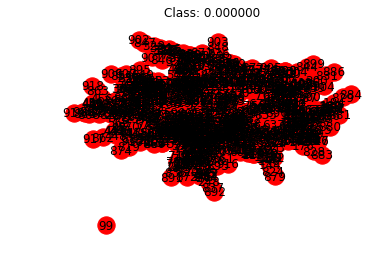

In [6]:
graph = trainset[14]
label=labels[14][0]

fig, ax = plt.subplots()
G=graph.to_networkx()
pos=nx.spring_layout(G)
nx.draw(G,pos)
nx.draw_networkx_labels(G,pos, ax=ax)
ax.set_title('Class: {:f}'.format(label))
plt.show()

### Apply random shuffle to training set

In [7]:
##apply random shuffle on the trainset    
randomize = np.arange(len(trainset))
np.random.shuffle(randomize)
labels_shuffled=[]
trainset_shuffled=[]
for i in range (len(randomize)):
    labels_shuffled.append(labels[randomize[i]])
    trainset_shuffled.append(trainset[randomize[i]])

In [8]:
import dgl

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [9]:
import dgl.function as fn
import torch
import torch.nn as nn


# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

Readout and classification
--------------------------
For this demonstration, consider initial node features to be their degrees.
After two rounds of graph convolution, perform a graph readout by averaging
over all node features for each graph in the batch.

\begin{align}h_g=\frac{1}{|\mathcal{V}|}\sum_{v\in\mathcal{V}}h_{v}\end{align}

In DGL, :func:`dgl.mean_nodes` handles this task for a batch of
graphs with variable size. You then feed the graph representations into a
classifier with one linear layer to obtain pre-softmax logits.



In [10]:
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float().cuda()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        del h
        return self.classify(hg)

Setup and training
------------------
Create a synthetic dataset of $400$ graphs with $10$ ~
$20$ nodes. $320$ graphs constitute a training set and
$80$ graphs constitute a test set.



In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
# trainset = MiniGCDataset(320, 10, 20)
# testset = MiniGCDataset(80, 10, 20)
#print(trainset)

In [12]:
# Use PyTorch's DataLoader and the collate function
# defined before.
#data_loader = DataLoader(trainset, batch_size=2, shuffle=True,
#                         collate_fn=collate)
#print(data_loader)
# Create model
#model = Classifier(1, 256, trainset.num_classes)
model = Classifier(1, 256, 2)
model.cuda()
loss_func = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

labels_shuffled = torch.LongTensor(labels_shuffled).cuda()

epoch_losses = []
for epoch in range(1000):
    model.train()
    epoch_loss = 0
    for iter, bg in enumerate(trainset_shuffled):
        prediction=torch.zeros(1,2,dtype=torch.float64).cuda()
        prediction[0] = model(bg)

        loss = loss_func(prediction, labels_shuffled[iter])
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 0.05)
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)
    if (epoch%5==0):
        model.eval()
        torch.no_grad()
        eval_bg = dgl.batch(trainset_shuffled)
        eval_labels = torch.tensor(labels_shuffled).float().view(-1, 1)
        probs_Y = torch.softmax(model(eval_bg), 1)
        argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)

        print('Accuracy of argmax predictions on the training set: {:4f}%'.format(
            (eval_labels == argmax_Y.float()).sum().item() / len(eval_labels) * 100))
    torch.cuda.empty_cache()

Epoch 0, loss 1.1138
Accuracy of argmax predictions on the training set: 50.000000%


/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1, loss 1.0196
Epoch 2, loss 0.9363
Epoch 3, loss 0.9185
Epoch 4, loss 0.9107
Epoch 5, loss 0.9038
Accuracy of argmax predictions on the training set: 50.000000%
Epoch 6, loss 0.8960
Epoch 7, loss 0.8884
Epoch 8, loss 0.8829
Epoch 9, loss 0.8787
Epoch 10, loss 0.8745
Accuracy of argmax predictions on the training set: 50.000000%
Epoch 11, loss 0.8707
Epoch 12, loss 0.8668
Epoch 13, loss 0.8630
Epoch 14, loss 0.8593
Epoch 15, loss 0.8553
Accuracy of argmax predictions on the training set: 50.000000%
Epoch 16, loss 0.8519
Epoch 17, loss 0.8470
Epoch 18, loss 0.8402
Epoch 19, loss 0.8346
Epoch 20, loss 0.8309
Accuracy of argmax predictions on the training set: 50.000000%
Epoch 21, loss 0.8266
Epoch 22, loss 0.8208
Epoch 23, loss 0.8166
Epoch 24, loss 0.8122
Epoch 25, loss 0.8089
Accuracy of argmax predictions on the training set: 50.000000%
Epoch 26, loss 0.8052
Epoch 27, loss 0.8023
Epoch 28, loss 0.7991
Epoch 29, loss 0.7959
Epoch 30, loss 0.7903
Accuracy of argmax predictions on 

RuntimeError: CUDA out of memory. Tried to allocate 86.00 MiB (GPU 0; 10.73 GiB total capacity; 9.70 GiB already allocated; 58.62 MiB free; 35.67 MiB cached)

The learning curve of a run is presented below.



In [ ]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

The trained model is evaluated on the test set created. To deploy
the tutorial, restrict the running time to get a higher
accuracy ($80$ % ~ $90$ %) than the ones printed below.



In [ ]:
print(model.layers[0].apply_mod.linear.weight.size())
print(model.layers[1].apply_mod.linear.weight.size())
model.classify.weight.size()

### Get Testset data

In [ ]:
testset = []
test_labels = []
test_dir = 'test_data'

testing_idx=[]
for i in range(4,65):
    if i not in training_idx:
        testing_idx.append(i)

print(testing_idx)
print(training_idx)

In [ ]:
for idx in testing_idx:
    node_list=[]
    edge_list=[]
    label_list=[]
    node_list2=[]
    edge_list2=[]
    label_list2=[]
    node_list3=[]
    edge_list3=[]
    label_list3=[]
    node_list4=[]
    edge_list4=[]
    label_list4=[]
    for j in ["node_list","edge_list","graph_label"]:
        filename = "cla_"+str(idx)+"bit"+j+'.csv'
        filename2 = "CSkipA_"+str(idx)+"bit"+j+'.csv'
        
        if(filename.find("node_list")>=0):
            with open(test_dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                node_list = list(reader)
                
        if(filename.find("edge_list")>=0):
            with open(test_dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list = list(reader)
        if(filename.find("graph_label")>=0):
            with open(test_dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                label_list = list(reader)
        if(filename.find("gate_type")>=0):
            with open(test_dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type = list(reader)
        
        if(filename2.find("node_list")>=0):
            with open(test_dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                node_list2 = list(reader)
                
        if(filename2.find("edge_list")>=0):
            with open(test_dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list2 = list(reader)
        if(filename2.find("graph_label")>=0):
            with open(test_dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                label_list2 = list(reader)
        if(filename2.find("gate_type")>=0):
            with open(test_dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type2 = list(reader)
    #create dgl graph
    g=build_circuit_graph_undirected(node_list,edge_list)
    testset.append(g)
    test_labels.append(label_list[0])
    g2=build_circuit_graph_undirected(node_list2,edge_list2)
    testset.append(g2)
    test_labels.append(['1'])


for i in test_labels:
    i[0] = int(i[0])

print(test_labels)

In [ ]:
##apply random shuffle on the testset    
randomize = np.arange(len(testset))
np.random.shuffle(randomize)
testset_shuffled=[]
test_labels_shuffled=[]
for i in range (len(randomize)):
    test_labels_shuffled.append(test_labels[randomize[i]])
    testset_shuffled.append(testset[randomize[i]])

In [ ]:
model.eval()
test_bg = dgl.batch(testset_shuffled)
test_labels = torch.tensor(test_labels_shuffled).float().view(-1, 1).cuda()
probs_Y = torch.softmax(model(test_bg), 1)


sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_labels == sampled_Y.float()).sum().item() / len(test_labels) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_labels == argmax_Y.float()).sum().item() / len(test_labels) * 100))

zip(model(test_bg),(test_labels))
for i1,i2 in zip(probs_Y,(test_labels)):
    print(i1,i2)
# print(torch.max(probs_Y, 1))

In [ ]:
import tsne

#m = trainset[0].adjacency_matrix()
m = model(test_bg).cpu().data.numpy()


In [ ]:
Y = tsne.tsne(m, 2, 30)

In [ ]:
print(Y)

In [ ]:
fig, axs = plt.subplots(2,2)


color = test_labels.cpu()*85/255
for i in range (len(test_labels)):
    axs[0,0].scatter(m[i,0],m[i,1],color=(0,color[i],0))
    axs[0,1].scatter(Y[i,0],Y[i,1],color=(0,color[i],0))
    

    
plt.show()